![](CompleNet.jpg)
# Toy example for a variational autoencoder

This is a very minimalistic application of an variational autoencoder, just reproducing a 2 dimensional density distribution.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Creating the data
The following data comes from a simple 2 dimensional distribution.

In [2]:
def next_batch(batch_size, non_crossing=True):
    z_true = np.random.uniform(0,1,batch_size)
    r = np.power(z_true, 0.5)
    phi = 0.25 * np.pi * z_true
    x1 = r*np.cos(phi)
    x2 = r*np.sin(phi)
    
    # Sampling form a Gaussian
    x1 = np.random.normal(x1, 0.10* np.power(z_true,2), batch_size)
    x2 = np.random.normal(x2, 0.10* np.power(z_true,2), batch_size)
        
    # Bringing data in the right form
    X = np.transpose(np.reshape((x1,x2), (2, batch_size)))
    X = np.asarray(X, dtype='float32')
    return X

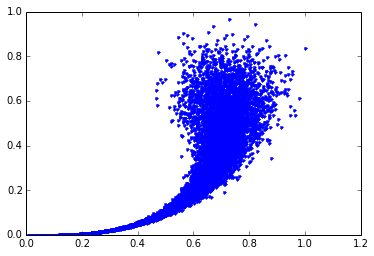

(10000, 2)

In [3]:
xx = next_batch(10000)
plt.plot(xx[:,0], xx[:,1], '.')
plt.show()
xx.shape

### Tensorflow
For this demo we use tensorflow...

In [4]:
import tensorflow as tf
print("Tensor Flow version {}".format(tf.__version__))

Tensor Flow version 0.8.0


In [5]:
# Functions to get variables
def weights(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

### Building the networks
#### The encoder network $q_\phi(z|x)$

The decoder network takes the input image and calculates the mean $\mu =$ `z_mu` and the log variance $\log\sigma^2 =$ `z_ls2` of the Gaussian, thus producing the latent variable z.

In [6]:
n_z = 1 #Dimension of the latent space
# Input
x = tf.placeholder("float32", shape=[None, 2]) #Batchsize x Number of Pixels
n_hidden_1 = 5
n_hidden_2 = 6

# First hidden layer
W_fc1 = weights([2, n_hidden_1])
b_fc1 = bias([n_hidden_1])
h_1   = tf.nn.softplus(tf.matmul(x, W_fc1) + b_fc1)

# Second hidden layer
W_fc2 = weights([n_hidden_1, n_hidden_2]) 
b_fc2 = bias([n_hidden_2])
h_2   = tf.nn.softplus(tf.matmul(h_1, W_fc2) + b_fc2)


# Parameters for the Gaussian
z_mu = tf.add(tf.matmul(h_2, weights([n_hidden_2, n_z])), bias([n_z]))
# A little trick:
#  sigma is always > 0.
#  We don't want to enforce that the network produces only positive numbers, therefore we let 
#  the network model the parameter log(\sigma^2) $\in [\infty, \infty]$
z_ls2 = tf.add(tf.matmul(h_2, weights([n_hidden_2, n_z])), bias([n_z])) 

#### The decoder network $p_\theta(x|z)$ a.k.a. generator network

Samples from a Gaussian using the given mean and the std. The sampling is done by addding a random number ensuring that backpropagation works fine.

In [7]:
batch_size = 640 #We have to define the batch size with the current version of TensorFlow
eps = tf.random_normal((batch_size, n_z), 0, 1, dtype=tf.float32) # Adding a random number
z = tf.add(z_mu, tf.mul(tf.sqrt(tf.exp(z_ls2)), eps))  # The sampled z

In [8]:
n_hidden_1 = 5
n_hidden_2 = 6

W_fc1_g = weights([n_z, n_hidden_1])
b_fc1_g = bias([n_hidden_1])
h_1_g   = tf.nn.softplus(tf.matmul(z, W_fc1_g) + b_fc1_g)

W_fc2_g = weights([n_hidden_1, n_hidden_2])
b_fc2_g = bias([n_hidden_2])
h_2_g   = tf.nn.softplus(tf.matmul(h_1_g, W_fc2_g) + b_fc2_g)

x_mu = tf.add(tf.matmul(h_2_g,  weights([n_hidden_2, 2])), bias([2]))
x_ls2 = tf.add(tf.matmul(h_2_g,  weights([n_hidden_2, 2])), bias([2]))

#### Defining the loss function

##### The reconstruction error
We assume that the data x, is Gaussian distributed with diagnoal covariance matrix $\Sigma_{ij} = \delta_{i,j} \sigma_i^2$. The parameters of that Gaussian are determined by the encoder network. The reconstruction error for the $i-th$ example in the min-batch is given by 
$$
    \mathbb{E}_{q(z|x^{(i)})}\left( \log\left(p(x^{(i)}|z)\right)\right) 
$$
we approximate the expectation with samplinging from the distribution (eaven with $L=1$)
$$
    \mathbb{E}_{q(z|x^{(i)})}\left( \log\left(p(x^{(i)}|z)\right)\right) \approx 
    \frac{1}{L} \sum_{i=1}^L \log\left(p(x^{(i)}|z^{(i,l)})\right) \approx \log\left(p(x^{(i)}|z^{(i,l)})\right)
$$

For the simple $J-dimensional$ Gaussian, we obtain the following reconstruction error (neglegting a constant term)
$$
    -\log\left(p(x^{(i)}|z^{(i)})\right) = \sum_{j=1}^D \frac{1}{2} \log(\sigma_{x_j}^2) + \frac{(x^{(i)}_j - \mu_{x_j})^2}{2 \sigma_{x_j}^2}
$$

##### The regularisation term

$$
    -D_{\tt{KL}} \left( q(z|x^{(i)}) || p(z) \right) = \frac{1}{2} \sum_{j=1}^{J} \left(1 + \log(\sigma_{z_j}^{(i)^2}) - \mu_{z_j}^{(i)^2} - \sigma_{z_j}^{(i)^2} \right)
$$

In [9]:
reconstr_loss = tf.reduce_sum(0.5 * x_ls2 + (tf.square(x-x_mu)/(2.0 * tf.exp(x_ls2))), 1)
latent_loss = -0.5 * tf.reduce_sum(1 + z_ls2 - tf.square(z_mu) - tf.exp(z_ls2), 1)
cost = tf.reduce_mean(reconstr_loss + latent_loss)   # average over batch

# Use ADAM optimizer
optimizer =  tf.train.AdamOptimizer(learning_rate=0.01).minimize(cost)

In [10]:
# This takes quite some time to converge. I am courious what would happen 
# if a proper optimizer is finally implemented in TensorFlow

runs = 0#2000 #Set to 0, for no training
init = tf.initialize_all_variables()
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(init)
    batch_xs = next_batch(batch_size)
    print(batch_xs.shape)
    dd = sess.run([cost], feed_dict={x: batch_xs})
    print('Test run after starting {}'.format(dd))

    for epoch in range(runs):
        avg_cost = 0.
        batch_xs = next_batch(batch_size)
        _,d, z_mean_val, z_log_sigma_sq_val = sess.run((optimizer, cost, z_mu, z_ls2), feed_dict={x: batch_xs})
        avg_cost += d / batch_size

        # Display logs per epoch step
        if epoch % 50 == 0:
            save_path = saver.save(sess, "model_2d/model2d.ckpt") #Saves the weights (not the graph)
            print("Model saved in file: {}".format(save_path))
            print "Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost)
            print ("{} {} mean sigma2 {}".format(z_mean_val.min(), z_mean_val.max(), np.mean(np.exp(z_log_sigma_sq_val))))
            

(640, 2)
Test run after starting [-0.0061045298]


In [11]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "model_2d/model2d.ckpt")
    x_sample = next_batch(batch_size)
    var = (x_mu, x_ls2, z, z_mu, z_ls2, cost, reconstr_loss, latent_loss)
    out = sess.run(var, feed_dict={x: x_sample})
    x_mu_val, x_ls2_val, z_vals, z_mu_val,z_ls2_val, cost_val, reconstr_loss_val,latent_loss_val = out

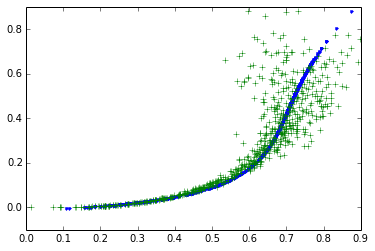

In [12]:
plt.plot(x_mu_val[:,0], x_mu_val[:,1], '.')
plt.plot(x_sample[:,0], x_sample[:,1], '+') 

In [13]:
# Sampling from z=-2 to z=2
z_vals = np.reshape(np.asarray(np.linspace(-2,2, batch_size), dtype='float32'), (batch_size,1))

In [14]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "model_2d/model2d.ckpt")
    x_mu_val, x_ls2_val = sess.run((x_mu, x_ls2), feed_dict={z: z_vals})

In [15]:
idx = np.linspace(0, batch_size-1, 20, dtype='int32')

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


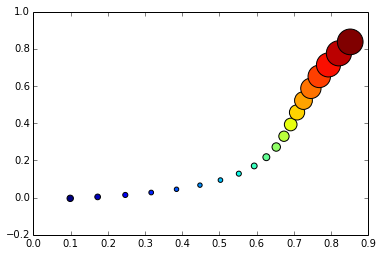

In [16]:
plt.scatter(x_mu_val[idx,0], x_mu_val[idx,1], c=z_vals[idx], s=60000* np.mean(np.exp(x_ls2_val[idx,:]), axis=1))